# CS-401, Final Milestone, Project
The following notebook contains the code for the final milestone of the project. The code is divided into 3 parts:
1. Data Pre-processing
2. Exploratory Analysis
3. Causal Analysis

# Presentation of the dataset
The dataset used in this project is a generated from a research paper on how users navigate through wikipedia pages. The dataset contains 3 main components:
1. The list of all articles in the dataset on which users can navigate.
2. The list of all outgoing links from each article.
3. The list of all games initiated by users, where each game is a sequence of articles visited by the user. These articles are finished or not finished (path_finished.tsv & path_unfinished.tsv).


# Part 0: Imports

In [63]:
# required non-standard packages to be installed for NLP
#!pip install -U sentence-transformers

We used the package "sentence-transformers" to... %TODO

In [15]:
# importing libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse as urlparse
from collections import defaultdict

from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import re
import os
import networkx as nx

from sentence_transformers import SentenceTransformer
from sklearn.metrics import pairwise


from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Part 1: Data Pre-processing
The pre-processing of the data is divided into 3 parts:
1. Data Loading, Transforming & Cleaning
2. Fine-Grained Analysis (Individual Links)
3. Coarse-Grained Analysis (Overall Articles)

## 1.1 Data Loading, Transforming & Cleaning
In this first section, we load the data from the dataset and transform it into a format that is easier to work with. We also clean the data by removing any unnecessary columns and rows.

The data is loaded from the following files:
1. path_finished.tsv
2. path_unfinished.tsv
3. links.tsv
4. articles.tsv
5. categories.tsv

The resulting data structures that are available are:
1. df_users_paths: All the paths taken by users in the dataset as a list of articles visited by the user. The target article and if the game was finished is also included. A first step of filtering is made to remove invalid paths.
2. df_links: All the links between articles in the dataset. The links are stored as a list of outgoing links from each article. Encoding and decoding of the links is done to make them easier to work with. Columns are added to store statistics about the links.
3. df_articles: All the articles in the dataset with encoding and decoding of the titles. A list of associated categories is included as a column.

In [63]:
# Helper functions for encoding and decoding.
def url_parse(url):
    """
    Parse URL encoded to readable characters
    """

    return urlparse.unquote(url).casefold()


def url_encode(url):
    """
    URL encode target links
    """

    return urlparse.quote(url)

We start by retrieving the players's data: they are in the paths_finished and paths_unfinished datasets.

In [64]:
# load finished paths
df_user_finished = pd.read_csv('./data/wikispeedia_paths-and-graph/paths_finished.tsv',
                      sep='\t',
                      names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'],
                      comment='#')

df_user_finished = df_user_finished.drop(['hashedIpAddress', 'timestamp', 'durationInSec', 'rating'], axis=1)

#create a column 'target' with the last article of each path to merge with unfinished paths
df_user_finished['target'] = df_user_finished['path'].apply(lambda x: x.split(';')[-1])

In [65]:
# load unfinished paths
df_user_unfinished = pd.read_csv('./data/wikispeedia_paths-and-graph/paths_unfinished.tsv',
                                 sep='\t',
                                 names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
                                 comment='#')

df_user_unfinished = df_user_unfinished.drop(['hashedIpAddress', 'timestamp', 'durationInSec', 'type'], axis=1)

In [66]:
# create a new column to store the path type to differentiate finished and unfinished paths after concatenation
df_user_finished['path_type'] = 'finished'
df_user_unfinished['path_type'] = 'unfinished'

# concatenate finished and unfinished paths into single dataframe
df_user_paths = pd.concat([df_user_finished, df_user_unfinished])

# users clicked on links in the footer (Terms & Conditions + Disclaimer) that are not articles per-say.
# remove all paths containing these links as it is not in the spirit of the game
## "wikipedia_text_of_the_gnu_free_documentation_license" is not an article!
not_an_article = ['Wikipedia_Text_of_the_GNU_Free_Documentation_License']

df_user_paths = df_user_paths[~df_user_paths.path.str.contains('|'.join(not_an_article))]

# decode URL encoding for paths, case fold
df_user_paths['path'] = df_user_paths['path'].apply(url_parse)
df_user_paths['target'] = df_user_paths['target'].apply(url_parse)

# transform paths to list of inputs (article names or <)
df_user_paths['path'] = df_user_paths['path'].str.split(';')

df_user_paths.head(10)

,path,target,path_type
0,"[14th_century, 15th_century, 16th_century, pac...",african_slave_trade,finished
1,"[14th_century, europe, africa, atlantic_slave_...",african_slave_trade,finished
2,"[14th_century, niger, nigeria, british_empire,...",african_slave_trade,finished
3,"[14th_century, renaissance, ancient_greece, gr...",greece,finished
4,"[14th_century, italy, roman_catholic_church, h...",john_f._kennedy,finished
5,"[14th_century, europe, north_america, united_s...",john_f._kennedy,finished
6,"[14th_century, china, gunpowder, fire]",fire,finished
7,"[14th_century, time, isaac_newton, light, colo...",rainbow,finished
8,"[14th_century, time, light, rainbow]",rainbow,finished
9,"[14th_century, 15th_century, plato, nature, ul...",rainbow,finished


We add the new columns of interest in the df_links dataframe, and initialize them:

In [67]:
# extract list of links as DataFrame
df_links = pd.read_csv('./data/wikispeedia_paths-and-graph/links.tsv',
                       sep='\t',
                       names=['linkSource_URL', 'linkTarget_URL'],
                       comment='#')
# Definitions:
## Source Links are the link of the page on which a link is shown
## Target Links are the outgoing link on which the user clicks

# Filenames are single encoded (ie C++.htm is encoded at C%2B%2B.htm)
# Outgoing names in the HTML source are DOUBLE encoded (ie C++.htm is <a href="../../wp/c/C%252B%252B.htm">

# add a helper column for linkTarget_2URL storing the DOUBLE URL ENCODED string
df_links['linkTarget_2URL'] = df_links['linkTarget_URL'].map(url_encode)
df_links['linkSource_2URL'] = df_links['linkSource_URL'].map(url_encode)

# decode URL encoding for paths, case fold (from URL encoding to readable)
df_links['linkSource'] = df_links['linkSource_URL'].map(url_parse)
df_links['linkTarget'] = df_links['linkTarget_URL'].map(url_parse)

# merge columns in tuple for easy lookup (unique key), format source;target
df_links['linkPair'] = df_links['linkSource'] + ';' + df_links['linkTarget']

# number of impressions will be counted in column 'impressions' for each pair
df_links['impressions'] = pd.Series(np.zeros((len(df_links)),dtype=int))

# number of hits will be counted in column 'hits' for each pair
df_links['clicks'] = pd.Series(np.zeros((len(df_links)),dtype=int))

# Storing the x and y position of the unique link pair on the page
df_links['xpos'] =  pd.Series(np.zeros((len(df_links)),dtype=int))
df_links['ypos'] =  pd.Series(np.zeros((len(df_links)),dtype=int))

# storing the similarity score between the source and target articles
df_links['title_similarity_score'] = pd.Series(np.zeros((len(df_links)),dtype=float))

# storing the length of each source article
df_links['length'] = pd.Series(np.zeros((len(df_links)),dtype=int))

df_links.head(10)

,linkSource_URL,linkTarget_URL,linkTarget_2URL,linkSource_2URL,linkSource,linkTarget,linkPair,impressions,clicks,xpos,ypos,title_similarity_score,length
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,Bede,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,bede,áedán_mac_gabráin;bede,0,0,0,0,0.0,0
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,Columba,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,columba,áedán_mac_gabráin;columba,0,0,0,0,0.0,0
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,D%25C3%25A1l_Riata,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,dál_riata,áedán_mac_gabráin;dál_riata,0,0,0,0,0.0,0
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,Great_Britain,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,great_britain,áedán_mac_gabráin;great_britain,0,0,0,0,0.0,0
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,Ireland,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,ireland,áedán_mac_gabráin;ireland,0,0,0,0,0.0,0
5,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,Isle_of_Man,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,isle_of_man,áedán_mac_gabráin;isle_of_man,0,0,0,0,0.0,0
6,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy,Monarchy,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,monarchy,áedán_mac_gabráin;monarchy,0,0,0,0,0.0,0
7,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney,Orkney,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,orkney,áedán_mac_gabráin;orkney,0,0,0,0,0.0,0
8,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Picts,Picts,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,picts,áedán_mac_gabráin;picts,0,0,0,0,0.0,0
9,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Scotland,Scotland,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,scotland,áedán_mac_gabráin;scotland,0,0,0,0,0.0,0


We store the list of articles in a DataFrame and decode/encode as required.

In [68]:
# load list of articles
df_articles = pd.read_csv('./data/wikispeedia_paths-and-graph/articles.tsv',
                          sep='\t',
                          names=['title_URL'],
                          comment='#')

# load list of categories for articles
df_categories = pd.read_csv('./data/wikispeedia_paths-and-graph/categories.tsv',
                            sep='\t',
                            names=['title_URL', 'category'],
                            comment='#')

# store article names in series as DOUBLE URL encoded
df_articles['title_2URL'] = df_articles['title_URL'].map(url_encode)

# decode URL encoding to readable characters for path analysis
df_articles['title'] = df_articles['title_URL'].map(url_parse)

# for every article in df_category, concatenate duplicate rows into a list
df_categories = df_categories.groupby('title_URL')['category'].apply(list).reset_index(name='categories')

# for all articles in df_articles, extract the category from df_categories on column 'title_URL'
df_articles = pd.merge(df_articles, df_categories, on='title_URL', how='left')

# for every article in df_category with NaN, replace with 'None
df_articles['categories'] = df_articles['categories'].fillna('No Category')

df_articles.head(10)

,title_URL,title_2URL,title,categories
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,[subject.History.British_History.British_Histo...
1,%C3%85land,%25C3%2585land,åland,"[subject.Countries, subject.Geography.European..."
2,%C3%89douard_Manet,%25C3%2589douard_Manet,édouard_manet,[subject.People.Artists]
3,%C3%89ire,%25C3%2589ire,éire,"[subject.Countries, subject.Geography.European..."
4,%C3%93engus_I_of_the_Picts,%25C3%2593engus_I_of_the_Picts,óengus_i_of_the_picts,[subject.History.British_History.British_Histo...
5,%E2%82%AC2_commemorative_coins,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,[subject.Business_Studies.Currency]
6,10th_century,10th_century,10th_century,[subject.History.General_history]
7,11th_century,11th_century,11th_century,[subject.History.General_history]
8,12th_century,12th_century,12th_century,[subject.History.General_history]
9,13th_century,13th_century,13th_century,[subject.History.General_history]


## 1.2: Fine Grained: Analysis on Specific Links (source;destination)
The goal is to expand the _links_ table by adding extra information.
For each pair _(origin article, destination article)_, columns counting the number of clicks associated, the number of impressions, the CTR, the position of links, the length of the article.

In [69]:
# Optimization step, preprocessing indices to use numpy arrays for faster access
# For all articles names, create a list of rows in the df_links that have this article as source
source_map = defaultdict(list)
for link_id, source in enumerate(df_links['linkSource']):
    source_map[source].append(link_id)

# Create a reverse dictionary to index nparray
# list[idx]=string to dict[string]=idx
my_map = dict(df_links['linkPair'])
pair_map = dict((v, k) for k, v in my_map.items())

### 1.2.1 Computing clicks, impressions and CTR
For each individual link pair (source;target), we count the number of clicks and impressions to compute the click-through rate (CTR).
This is done by analysing all finished and unfinished paths of users playing the game.

In [70]:
np_links = df_links.to_numpy()
IMPRESSIONS_COLUMN_ID = df_links.columns.get_loc('impressions')
CLICKS_COLUMN_ID = df_links.columns.get_loc('clicks')
XPOS_COLUMN_ID = df_links.columns.get_loc('xpos')
YPOS_COLUMN_ID = df_links.columns.get_loc('ypos')

# create iterable series of paths
series_paths = df_user_paths['path'].squeeze()

for path in series_paths:
    # initialise stack with first link
    foo = list()
    foo.append(path[0])
    # iterate over every step of user's path
    for element in path[1:]:
        if element != '<':
            # if next element in path is not a return character, store information and analyze
            ## source node is the current top of stack
            source_node = foo[-1]

            ## add next link in list to top of stack
            foo.append(element)

            ## new top of stack is target
            target_node = foo[-1]

            # create key for pair identification
            search_value = source_node + ';' + target_node

            try:
                pair = pair_map[search_value]
            except Exception as e:
                # catch when pair was not listed in dataset, don't add impression and disregard
                print('Invalid pair:',e)
                break

            ## count one impression for all pairs with source_node as source (source_node;*)
            source = source_map[source_node]
            np_links[source,IMPRESSIONS_COLUMN_ID] += 1

            ## add one click-through for the pair (source_node;target_node)
            np_links[pair,CLICKS_COLUMN_ID] += 1

        else:
            # if return character is read, pop top of stack and don't store any info
            foo.pop()

Invalid pair: 'finland;åland'
Invalid pair: 'finland;åland'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'claude_monet;édouard_manet'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'claude_monet;édouard_manet'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'finland;åland'
Invalid pair: 'finland;åland'
Invalid pair: 'ireland;éire'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'ireland;éire'
Invalid pair: 'impressionism;édouard_manet'
Invalid pair: 'claude_monet;édouard_manet'
Invalid pair: 'francisco_goya;édouard_manet'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'ireland;éire'
Invalid pair: 'ireland;éire'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'claude_monet;édouard_manet'
Invalid pair: 'republic_of_ireland;éire'


### Invalid pairs: Interpretation
Some issues were discovered with the dataset: some link pairs are missing from the list of links (*links.tsv*).
**The users clicked on a link that was not listed in the links.tsv file, but existed on the page.**

This was confirmed by going to the source page (ie *finland*) and confirming that there was a link to the destination (ie *åland*), but this link pair was not listed in the links.tsv source file.

Let's put back the values obtained in np_links in the df_links dataframe, since dataframes are easier to handle than numpy arrays

In [71]:
columns = df_links.columns
to_dict_values = {}

for i in range(len(columns)):
    col = columns[i]
    to_dict_values[col] = [np_links[k][i] for k in range(len(np_links))]

df_links = pd.DataFrame(to_dict_values)

Now, we can finally compute the CTR for each link pair.

In [72]:
df_links['CTR'] = df_links.clicks / df_links.impressions

## 1.2.2 NLP model (BERT) to encode the links and the articles' title
%TODO EXPLAIN

In [73]:
model = SentenceTransformer('efederici/sentence-bert-base')

def embed(input):
  return model.encode(input)

## 1.2.3 Computing the physical location of the links in the HTML pages
In this part, we compute the physical location of every link pair (source;destination) in a given HTML page by rendering a virtual page and using Selenium to get the coordinates of the links.

We create an HTML driver that renders pages in memory. We consider a full screen display to be 1680*900, rendered in Google Chrome.

In [74]:
op = Options()
op.add_argument('headless')
op.add_argument('window-size=1680,900')
driver = webdriver.Chrome(options=op)
THRESHOLD = 900

Now that the driver is configured, let's compute the locations of all links in the articles.

*Note that this step takes a long time to run, if it was already executed, load output_links.csv instead*

In [75]:
def embedding(x):
    return np.transpose(np.expand_dims(embed(x), axis=-1))

In [16]:
# for tracking progress
article_counter = 0
number_of_articles = len(df_articles['title_2URL'])

# check if file exists and if user wants to overwrite it
answer = 'y' # by default, create output file
if os.path.isfile('output/output_links.csv'):
    answer = input('File already exists, do you want to overwrite it? (y/n)')

if answer == 'n':
    df_links = pd.read_csv('output/output_links.csv')
else:
    for index,row in df_articles.iterrows():
        source = row['title_2URL']
        source_categories = row['categories']

        # progress tracking
        print('Current Article:',source,article_counter,'/',number_of_articles )
        article_counter+=1

        # embed the source title with BERT model to use later for semantic similarity
        source_title_embedding =  embedding(source)

        source_category_embedding = embedding(' '.join(source_categories))

        # compute relative path to html
        source_path = '/data/wpcd/wp/' + source[0].lower() + '/' + source + '.htm'

        # absolute path to html file
        user_cwd = os.getcwd().replace('\\','/')
        source_url = 'file://'+user_cwd+source_path
        # open the browser
        driver.get(source_url)

        # list of target links we want to find positions for
        list_target_articles = df_links.loc[df_links['linkSource_2URL']==source]['linkTarget_2URL']

        # length of each source article
        len_article = driver.execute_script("return document.body.scrollHeight")

        for target in list_target_articles:
            # embed the target title with BERT model to use later for semantic similarity
            target_title_embedding = embedding(target)
            target_category = df_articles.loc[df_articles['title_2URL']==target]['categories'].values[0]
            target_category_embedding = embedding(' '.join(target_category))

            # the pairs are in readable characters, target is double encoded format
            target_readable = url_parse(url_parse(target))
            source_readable = url_parse(url_parse(source))
            search_pair = source_readable + ';' + target_readable

            try:
                current_pair = pair_map[search_pair]
            except Exception as e:
                # catch when pair was not listed in dataset
                print('Invalid pair:',e) # for debug
                break

            # find the href with /target.htm in all elements of page
            ## example with target = World War I, we are looking for /World_War_I.htm
            href=driver.find_elements(By.XPATH,  ".//a[contains(@href,'/" + target + ".htm')]")
            try:
                df_links.loc[current_pair, 'xpos']=href[0].location['x']
                df_links.loc[current_pair, 'ypos']=href[0].location['y']
                df_links.loc[current_pair, 'length'] = len_article
                # if pos_y is bigger than 900, set column is_on_top to 1, else 0
                df_links.loc[current_pair, 'is_on_top'] = 1 if href[0].location['y'] < THRESHOLD else 0
                df_links.loc[current_pair, 'title_similarity_score'] = pairwise.cosine_similarity(source_title_embedding, target_title_embedding).item()
                df_links.loc[current_pair, 'category_similarity_score'] = pairwise.cosine_similarity(source_category_embedding, target_category_embedding).item()
            except Exception as e:
                print('Not found:',target)
        df_links.to_csv('./output/output_links.csv',encoding='utf-8-sig')
    driver.close()

Current Article: %25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in 0 / 4604
Current Article: %25C3%2585land 1 / 4604
Current Article: %25C3%2589douard_Manet 2 / 4604
Current Article: %25C3%2589ire 3 / 4604
Current Article: %25C3%2593engus_I_of_the_Picts 4 / 4604
Current Article: %25E2%2582%25AC2_commemorative_coins 5 / 4604
Current Article: 10th_century 6 / 4604
Current Article: 11th_century 7 / 4604
Current Article: 12th_century 8 / 4604
Current Article: 13th_century 9 / 4604
Current Article: 14th_century 10 / 4604
Current Article: 15th_Marine_Expeditionary_Unit 11 / 4604
Current Article: 15th_century 12 / 4604
Current Article: 16_Cygni 13 / 4604
Current Article: 16_Cygni_Bb 14 / 4604
Current Article: 16th_century 15 / 4604
Current Article: 1755_Lisbon_earthquake 16 / 4604
Current Article: 17th_century 17 / 4604
Current Article: 1896_Summer_Olympics 18 / 4604
Current Article: 18th_century 19 / 4604
Current Article: 1928_Okeechobee_Hurricane 20 / 4604
Current Article: 1973_oil_crisis 21 / 4

In [21]:
# invert df_links 0 = 1 and 1 = 0
df_links['is_on_top'] = 1 - df_links['is_on_top']
df_links.head(10)

,Unnamed: 0,linkSource_URL,linkTarget_URL,linkTarget_2URL,linkSource_2URL,linkSource,linkTarget,linkPair,impressions,clicks,xpos,ypos,title_similarity_score,length,CTR,is_on_top,category_similarity_score
0,0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,Bede,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,bede,áedán_mac_gabráin;bede,0,0,19,113,0.178801,1321,NaN,1.0,0.942970
1,1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,Columba,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,columba,áedán_mac_gabráin;columba,0,0,935,75,0.033332,1321,NaN,1.0,0.611777
2,2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,D%25C3%25A1l_Riata,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,dál_riata,áedán_mac_gabráin;dál_riata,0,0,209,75,0.844346,1321,NaN,1.0,0.957844
3,3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,Great_Britain,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,great_britain,áedán_mac_gabráin;great_britain,0,0,783,94,0.159667,1321,NaN,1.0,0.806819
4,4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,Ireland,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,ireland,áedán_mac_gabráin;ireland,0,0,593,75,0.116354,1321,NaN,1.0,0.683284
5,5,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,Isle_of_Man,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,isle_of_man,áedán_mac_gabráin;isle_of_man,0,0,1095,94,0.111435,1321,NaN,1.0,0.752308
6,6,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy,Monarchy,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,monarchy,áedán_mac_gabráin;monarchy,0,0,279,75,0.059908,1321,NaN,1.0,0.589547
7,7,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney,Orkney,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,orkney,áedán_mac_gabráin;orkney,0,0,982,94,0.087454,1321,NaN,1.0,0.752308
8,8,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Picts,Picts,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,picts,áedán_mac_gabráin;picts,0,0,388,442,0.122016,1321,NaN,1.0,0.979820
9,9,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Scotland,Scotland,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,scotland,áedán_mac_gabráin;scotland,0,0,428,75,0.023317,1321,NaN,1.0,0.752308


## 1.3: Coarse-Grained: Aggregated View over Whole Dataset
Here, the goal is to extend the _articles_ table by adding columns representing the total number of clicks, the number of impressions and the CTR. Except for the CTR, we can simply sum the obtained numbers in the finer granularity.

In [3]:
df_links=pd.read_csv("./output/output_links.csv")

In [77]:
# add to df articles
# category
df_articles_coarse = df_links[["linkTarget", "impressions", "clicks"]].groupby(by=["linkTarget"]).sum()
df_articles_coarse["CTR"] = df_articles_coarse["clicks"]/df_articles_coarse["impressions"]

### Coarse-grained dataset: Aggregated view over all website
Here, the goal is to extend the _articles_ table by adding columns representing the total number of clicks, the number of impressions and the CTR. Except for the CTR, we can simply sum the obtained numbers in the finer granularity.

Let's extract the articles data by aggregating the df_links dataframe

# Part 2:Exploratory Data Analysis

Let's save the result

In [26]:
df_articles_coarse.to_csv('./output/output_articles.csv',encoding='utf-8-sig')

In [27]:
G = nx.DiGraph()
G = nx.from_pandas_edgelist(df_links, source='linkSource', target='linkTarget')

## Understanding the Wikispeedia network

To have a better understanding of the structure of the links, we wish to create a graph of the network.

In [28]:
G = nx.DiGraph()
G = nx.from_pandas_edgelist(df_links, source='linkSource', target='linkTarget')

In [30]:
nx.draw_networkx(G, with_labels=False, node_size=5, node_color="#001f3f", width=0.1, edge_color="#AAAAAA")
ax = plt.gca()
ax.set_title('Links Network')

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

Interestingly, we distinguish two strongly separate connected components. We can verify that easily:

In [102]:
print("There are " + str(nx.number_connected_components(G)) + "  connected components in the graph.")

In [103]:
print("Unconnected components: "+ str(list(nx.connected_components(G))[1]))

SyntaxError: invalid syntax (1198146831.py, line 1)

In [110]:
G = nx.from_pandas_edgelist(df_links, source='linkSource', target='linkTarget', create_using=nx.DiGraph)
nx.draw_networkx(G, with_labels=False, node_size=5, node_color="#001f3f", width=0.1, edge_color="#AAAAAA")
ax = plt.gca()
ax.set_title('Links Network')
plt.show()

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

In [4]:
#Drop pairs with NaN CTR. These are unreached links and we won't use them in our analysis since the player never reached these articles
df_links.dropna(subset=['CTR'],inplace=True)

The wikispeedia network becomes :

In [112]:
G = nx.from_pandas_edgelist(df_links, source='linkSource', target='linkTarget', create_using=nx.DiGraph)
nx.draw_networkx(G, with_labels=False, node_size=5, node_color="#001f3f", width=0.1, edge_color="#AAAAAA")
ax = plt.gca()
ax.set_title('Links Network')

NameError: name 'in_degree' is not defined

We, now, investigate the number of links pointing toward each article. 

In [113]:
# Return the number of edges pointing to the node
in_degree = G.in_degree()

NameError: name 'pd_graph' is not defined

In [31]:
# Transform the output into a dataframe for better use
pd_graph = pd.DataFrame(in_degree, columns=['articles', 'In degree'])
pd_graph.head(10)

,articles,In degree
0,€2_commemorative_coins,0
1,athens,83
2,atlantic_ocean,237
3,austria,224
4,belgium,223
5,berlin,129
6,brussels,64
7,cathedral_of_magdeburg,1
8,cereal,64
9,christopher_columbus,67


Let's visualize the distribution of the in degree values over the articles.

<AxesSubplot:title={'center':'In degree distribution'}, ylabel='Frequency'>

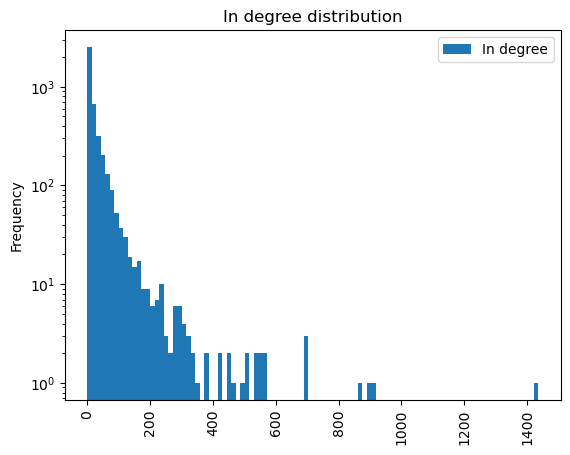

In [34]:
pd_graph.plot.hist(bins=100, rot=90, title= "In degree distribution", logy=True)

Let's rank the top 10 articles having the largest in degree value.

In [35]:
pd_graph.sort_values(by=['In degree'], ascending=False).head(10)

,articles,In degree
44,united_states,1435
42,united_kingdom,915
15,france,902
134,europe,866
17,germany,700
98,england,698
187,world_war_ii,698
58,india,573
941,english_language,561
241,japan,546


## Data Distribution

Let's explore the dataset we have obtained.

In [78]:
print('There exist', len(df_links), 'links in total.','\n')
print('The unique articles are:', df_links.linkSource.nunique())
df_links['linkSource'].value_counts()

There exist 119882 links in total. 

The unique articles are: 4587


united_states                     294
driving_on_the_left_or_right      255
list_of_countries                 244
list_of_circulating_currencies    236
list_of_sovereign_states          216
                                 ... 
lighting_designer                   1
soil_structure                      1
pro_milone                          1
soil_profile                        1
human_dignity                       1
Name: linkSource, Length: 4587, dtype: int64

Text(0.5, 0, 'Article')

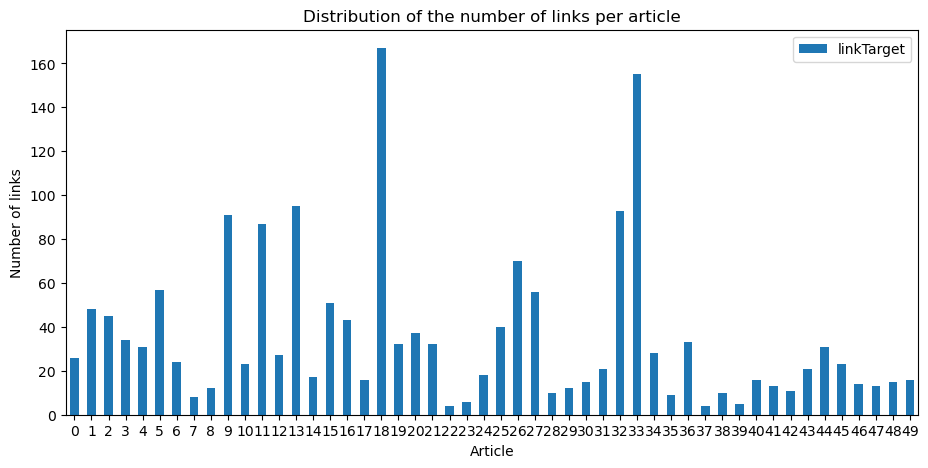

In [79]:
group_by_links = df_links.groupby(by=df_links.linkSource).count().linkTarget.reset_index()[:50]

pl = group_by_links.plot(kind='bar', figsize=[11,5], rot=0)
pl.set_title('Distribution of the number of links per article')
pl.set_ylabel('Number of links')
pl.set_xlabel('Article')

We can see that the number of links per article does not follow a uniform distribution. There are articles that have more than 160 links while others have less than 20.

<AxesSubplot:title={'center':'Number of clicks'}, ylabel='Frequency'>

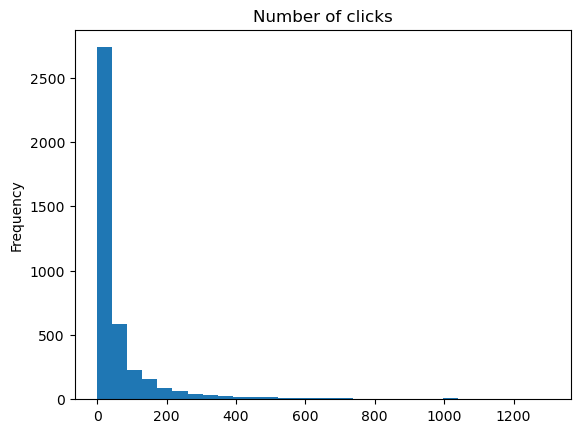

In [81]:
df_articles_coarse["clicks"].plot.hist(bins=30, range=[0,1300], title="Number of clicks")

Let's rank the top 10 most clicks articles:

In [82]:
df_articles_coarse.sort_values(by=['clicks'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
united_states,154518,12376,0.080094
europe,133170,5565,0.041789
united_kingdom,123566,5303,0.042916
england,65232,4413,0.067651
earth,61419,4172,0.067927
africa,68411,3490,0.051015
world_war_ii,102791,2893,0.028144
north_america,70097,2546,0.036321
animal,42468,2426,0.057125


Now focusing on impressions:

<AxesSubplot:title={'center':'Number of impressions'}, ylabel='Frequency'>

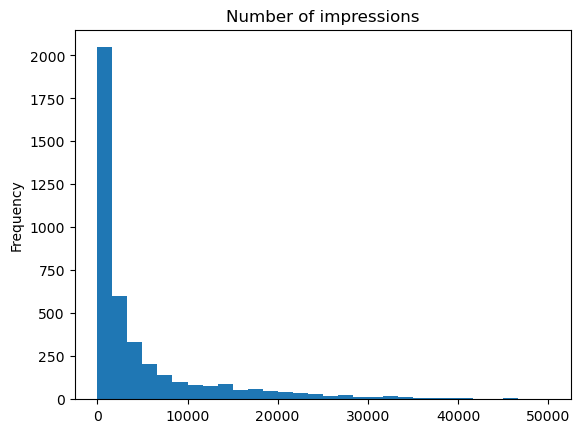

In [83]:
df_articles_coarse["impressions"].plot.hist(bins=30, title="Number of impressions", range=[0,50000])

Let's rank the top 10 articles with highest impressions

In [84]:
df_articles_coarse.sort_values(by=['impressions'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
united_states,154518,12376,0.080094
europe,133170,5565,0.041789
france,132404,2225,0.016805
united_kingdom,123566,5303,0.042916
germany,105443,2167,0.020551
world_war_ii,102791,2893,0.028144
latin,101089,959,0.009487
india,97125,1750,0.018018
spain,93086,773,0.008304


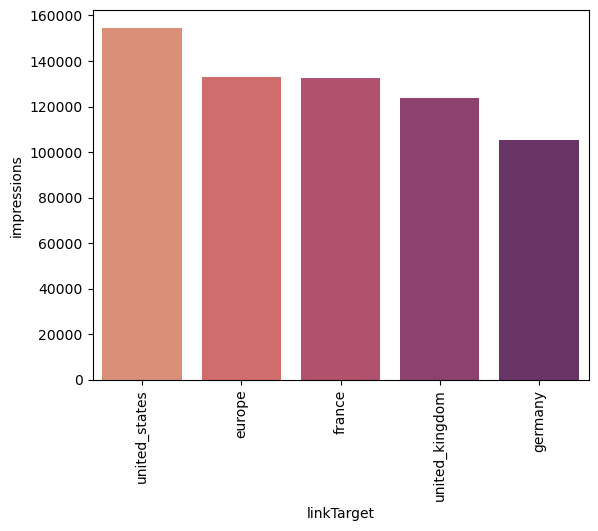

In [97]:
df_top_5_impressions=df_articles_coarse.sort_values(by=['impressions'], ascending=False).head(5).reset_index()
ax = sns.barplot(x="linkTarget", y="impressions", data=df_top_5_impressions,palette='flare')
plt.xticks(rotation=90)
plt.show()

The finaly analysis is made on CTR:

<AxesSubplot:title={'center':'Distribution of CTR'}, ylabel='Frequency'>

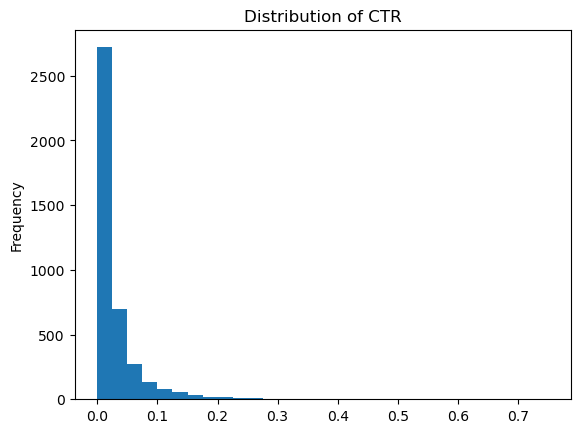

In [85]:
df_articles_coarse["CTR"].plot.hist(bins=30, title="Distribution of CTR", range=[0,0.75])

With the top 10 CTR ranking:

In [86]:
df_articles_coarse.sort_values(by=['CTR'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
list_of_european_countries,4,3,0.750000
exploration_of_mars,23,15,0.652174
wta_tour_championships,9,5,0.555556
the_lion_king,501,277,0.552894
gray_reef_shark,26,14,0.538462
ffestiniog_railway,2,1,0.500000
shenzhou_spacecraft,23,11,0.478261
battle_of_bicocca,13,6,0.461538
irish_theatre,14,6,0.428571


This last ranking might not be very useful since some articles have very low impressions, meaning we don't have enough data. The obtained CTR seem very high.

In [87]:
print("The average number of clicks is " + str(df_articles_coarse.clicks.mean()))
print("The average number of impressions is " + str(df_articles_coarse.impressions.mean()))
print("The average CTR is " + str(df_articles_coarse.CTR.mean()))

The average number of clicks is 88.35985489721887
The average number of impressions is 5661.276420798065
The average CTR is 0.030189658307541403


Let's visualize the links positions and clicks to show the regions with high click frequency. We adopt heatmaps to highlight these regions.

In [33]:
df_heatmap=df_links[['xpos','ypos','clicks','impressions','CTR']]

In [34]:
df_heatmap.sample(20)

,xpos,ypos,clicks,impressions,CTR
86899,450,157,12,62,0.193548
3754,1750,392,1,20,0.050000
113756,569,1852,0,65,0.000000
24402,23,2170,0,68,0.000000
86267,1586,492,0,41,0.000000
72474,926,1323,2,16,0.125000
13171,1163,265,282,895,0.315084
3690,1761,522,0,5,0.000000
85725,1659,117,47,1019,0.046124
108827,145,4003,0,158,0.000000


Now, let's see where in a page are located the links with highest clicks.

Text(0.5, 1.0, 'Clicks Heatmap')

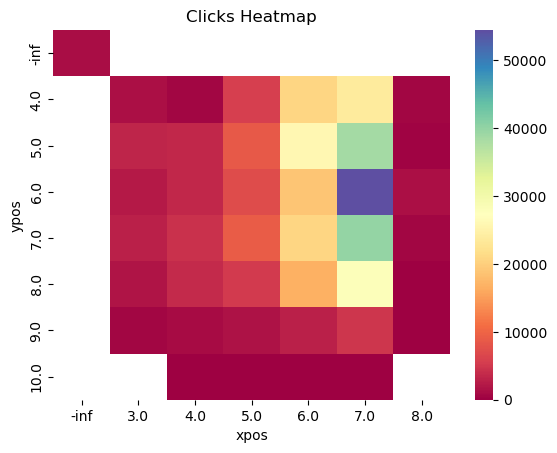

In [36]:
ax = plt.axes()
df_heatmap_clicks = pd.crosstab(np.around(np.log(df_heatmap['ypos'])),np.around(np.log(df_heatmap['xpos'])),values=df_heatmap['clicks'],aggfunc=sum)
sns.heatmap(df_heatmap_clicks,cmap=sns.color_palette("Spectral", as_cmap=True))
ax.set_title('Clicks Heatmap')

We can compare that to the places where the links appear in average on a page:

Text(0.5, 1.0, 'Impressions Heatmap')

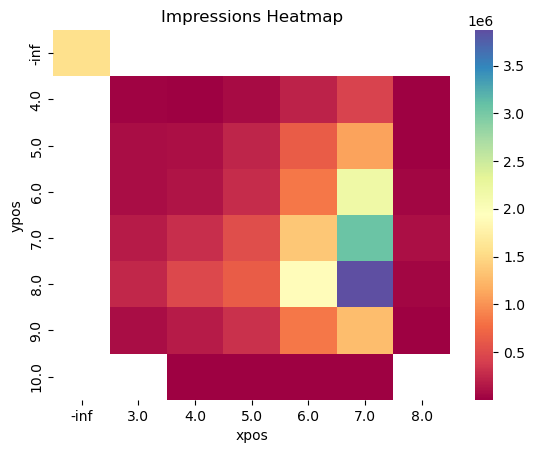

In [37]:
ax = plt.axes()
df_heatmap_impressions = pd.crosstab(np.around(np.log(df_heatmap['ypos'])),np.around(np.log(df_heatmap['xpos'])),values=df_heatmap['impressions'],aggfunc=sum)
sns.heatmap(df_heatmap_impressions,cmap=sns.color_palette("Spectral", as_cmap=True))
ax.set_title('Impressions Heatmap')

And finally, let's try to understand where the links with highest CTR are located:

Text(0.5, 1.0, 'CTR Heatmap')

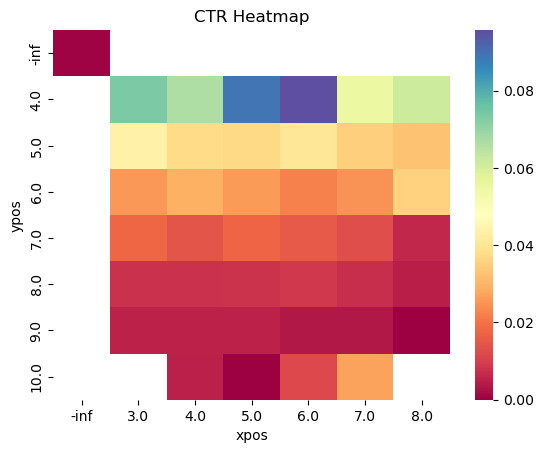

In [38]:
ax = plt.axes()
df_heatmap_CTR = df_heatmap_clicks/df_heatmap_impressions
sns.heatmap(df_heatmap_CTR,cmap=sns.color_palette("Spectral", as_cmap=True))
ax.set_title('CTR Heatmap')

These heatmaps are only the first iteration and will be made more clear for the next milestone.

Let's now investigate the relationship between two variables

In [39]:
df_links = df_links.fillna(0)
print(stats.pearsonr(df_links['xpos'],df_links['CTR']))

PearsonRResult(statistic=0.02024533074008124, pvalue=8.174436083074256e-12)


There is a very small (0.02), but significant (p < 0.05) positive correlation

In [40]:
print(stats.pearsonr(df_links['ypos'],df_links['CTR']))

PearsonRResult(statistic=-0.2073982284292976, pvalue=0.0)


There is a small (-0.2), but significant (p < 0.05) negative correlation. The pearson correlation coefficient for y position is 10 times higher than the one for x position.

Finally, we plot ypos/CTR and fit a regression model 

Text(0.5, 1.0, 'Linear Regression of CTR on ypos')

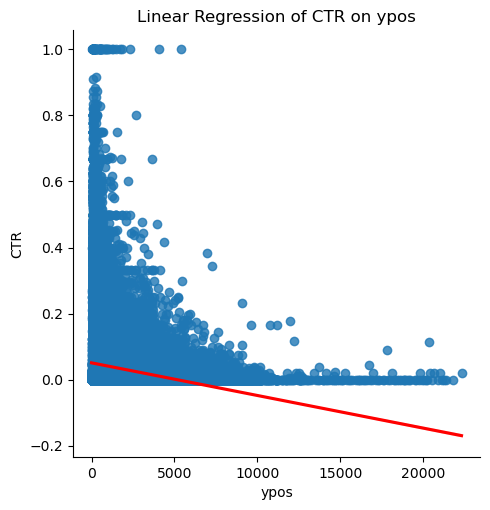

In [42]:
sns.lmplot(x="ypos", y="CTR", data=df_links, line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title('Linear Regression of CTR on ypos')

We plan to continue the investigations with additionnal features, and plot more intuitive visualizations. 

## Observational study

Let's first define the treated and control groups. Treated group are the links that happened to be at the top of an article. 

In [5]:
df_treatment = df_links.loc[df_links['is_on_top'] == 1]
df_control = df_links.loc[df_links['is_on_top'] == 0]

Now, we are interested in comparing the outcome variable, the CTR, in both groups as a first analysis.

In [6]:
df_treatment.CTR.describe() # statistical description of the CTR in the treated group

count    57395.000000
mean         0.055285
std          0.098601
min          0.000000
25%          0.000000
50%          0.015152
75%          0.071356
max          1.000000
Name: CTR, dtype: float64

In [7]:
df_control.CTR.describe() # statistical description of the CTR in the control group

count    56576.000000
mean         0.017656
std          0.043458
min          0.000000
25%          0.000000
50%          0.000000
75%          0.016949
max          1.000000
Name: CTR, dtype: float64

What about the CTR density distribution in both groups?

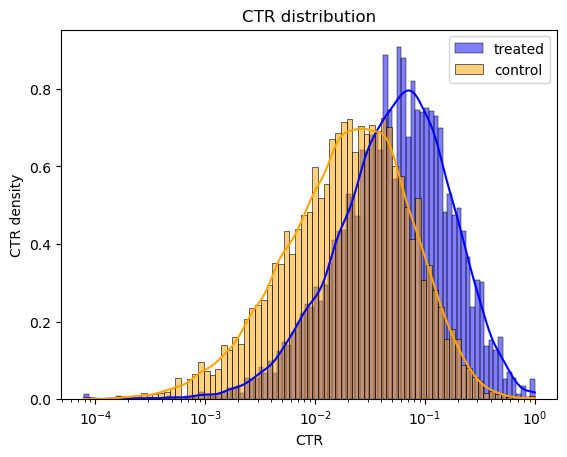

In [8]:
# Remove null values because log_scale is set to true for better visualization
df_treatment = df_treatment.loc[df_treatment["CTR"] != 0] 
df_control = df_control.loc[df_control["CTR"] != 0]

ax = sns.histplot(df_treatment['CTR'], stat='density', kde=True,  color='blue', label='treated', log_scale=True)
ax = sns.histplot(df_control['CTR'], stat='density', kde=True,  color='orange', label='control', log_scale=True)
ax.set(title='CTR distribution',xlabel='CTR', ylabel='CTR density')
plt.legend()
plt.show()

The treated group has:
- higher mean CTR value 
- higher percentile (50%, 75%)
- 75% of the CTR values lie below 0.071
- 50% of the CTR values lie below 0.015

The control group has:

- lower mean CTR value 
- lower percentile (50%, 75%)
- 75% of the CTR values lie below 0.016
- 50% of the CTR values lie below 0.0 (or equal to 0 as CTR > 0)

We conclude that, in general, the treated group have higher CTR values than the control one.

### Let's take a closer look at the data

As the data was gathered on individual behaviors in the scope of the Wikispeedia game, observational studies become a pillar in a causal analysis. 

First, we could think of the **source article length** as a confounder acting on the link position. 

Second, the semantic similarity between a link and the article in which it exists could affect its position. For example, we can expect that links that are most related to the article are at the top since they gather the most important information. Thus, the **semantic similarity** could act as a confounder since not all links have the same probabilities to be at the top of an article. 

In this section, we discover the distribution of these confounders in both the treated and control group to assess our hypotheses through different visualizations.

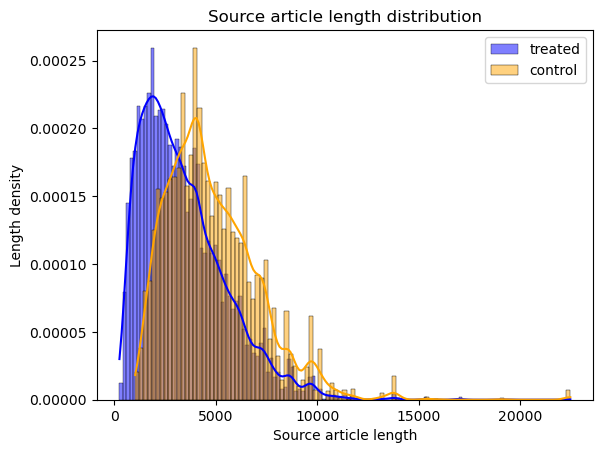

In [9]:
#Confounder 1: source article length

ax = sns.histplot(df_treatment['length'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(df_control['length'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Source article length distribution',xlabel='Source article length', ylabel='Length density')
plt.legend()
plt.show()

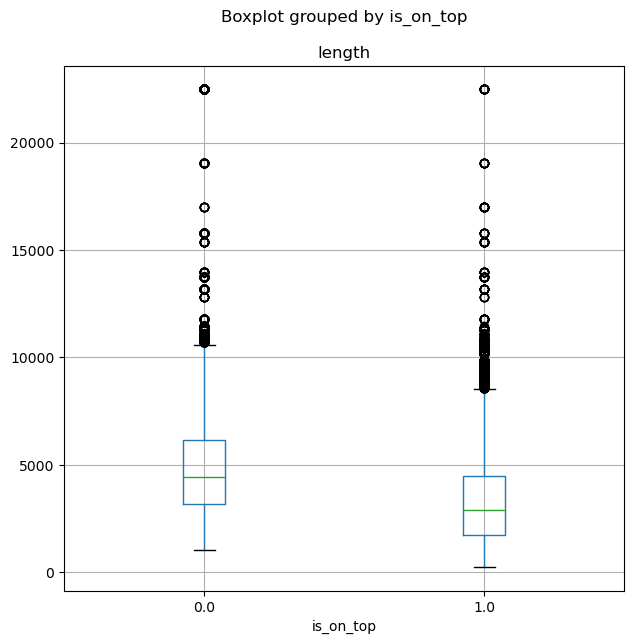

In [10]:
#Confounder 1: source article length

df_links.boxplot(by='is_on_top', column='length', figsize = [7, 7], grid=True)
plt.show()

From the graphs above, one can see that links that are at the top tend to exist in shorter articles. This might give an intuition of how much the source article length affect its target links position. 

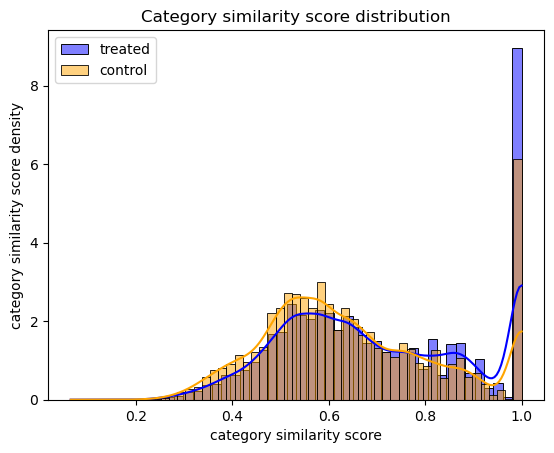

In [11]:
#Confounder 2: semantic similarity score between links and articles in which they exists

ax = sns.histplot(df_treatment['category_similarity_score'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(df_control['category_similarity_score'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Category similarity score distribution',xlabel='category similarity score', ylabel='category similarity score density')
plt.legend()
plt.show()

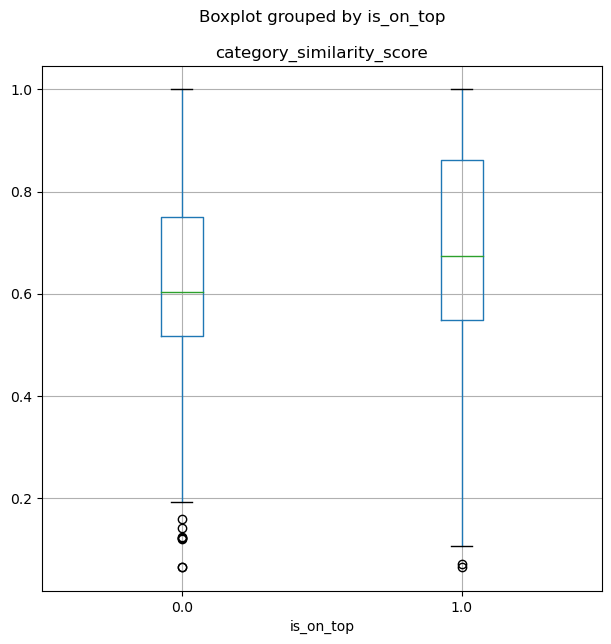

In [12]:
#Confounder 2: semantic similarity score between links and articles in which they exists

df_links.boxplot(by='is_on_top', column='category_similarity_score', figsize = [7, 7], grid=True)
plt.show()

As we can observe from the two plots above, links existing at the top tend to be more semantically related to their corresponding source article. 

### A propensity score model

A way to handle covariates is by matching links into pairs (treated, control) with respect to their propensity score. The propensity score can be measured through a logistic regression and for each data point, it represents its probability to be at the top of an article given the proposed covariates, features.

In [13]:
# let's standardize the continuous covariates
df_links['length'] = (df_links['length'] - df_links['length'].mean())/df_links['length'].std()
df_links['category_similarity_score'] = (df_links['category_similarity_score'] - df_links['category_similarity_score'].mean())/df_links['category_similarity_score'].std()

# logistic regression
mod = smf.logit(formula='is_on_top ~ length + category_similarity_score ', data=df_links)

res = mod.fit()

# Extract the propensity scores
df_links['Propensity_score'] = pd.Series(res.predict())

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.622874
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              is_on_top   No. Observations:               113971
Model:                          Logit   Df Residuals:                   113968
Method:                           MLE   Df Model:                            2
Date:                Thu, 22 Dec 2022   Pseudo R-squ.:                  0.1013
Time:                        23:27:51   Log-Likelihood:                -70990.
converged:                       True   LL-Null:                       -78996.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.0097      0.006     -1.518      0.129      -0.

From the logistic regression summary obtained above, the p-values (=0.000) confirm the effect of the source article length and the similarity score on the link position since they are less than 0.05, resulting in a significant effect.

### Matching

As the probability for two data points to have the same propensity score (real values) is negligeable, approximate matching is performed. For this, we use a K-nearest neighbors model to get the k closest neighbors to each link with respect to their propensity score. Then, each treated link is matched with a control link if this latter is considered as one of its neighbors. They share the same range of propensity scores within a chosen radius.

In [33]:
# Update dataframes
df_treatment = df_links.loc[df_links['is_on_top'] == 1]
df_control = df_links.loc[df_links['is_on_top'] == 0]

# Remove NaN values (sanity check):
df_links.dropna(inplace=True)


# Here, we define the K-NN hyperparameters: radius and number of neighbors. 
# These latter have been carefully chosen after several tests.

# We choose the K-nn model to vote among neighbors within 25% of standard deviation of the propensity score radius.
radius_neighbors = np.std(df_links['Propensity_score']) * 0.25

# We choose 10 as the number of neighbors to be used in the model.
num_neighbors = 10

# K-NN 
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=num_neighbors, radius=radius_neighbors)

# Extract the Propensity_score column
Propensity_score = df_links[['Propensity_score']]

# fit the K-NN model to the extracted column 
knn.fit(Propensity_score)

NearestNeighbors(n_neighbors=10, radius=0.04485575344354285)

In [17]:
# Run the K-NN model to extract for each datapoint, its neighbors ids.
_, neighbor_ids = knn.kneighbors(Propensity_score)

In [18]:
df_links.reset_index(inplace=True)

In [19]:
matching = [] # store the matched data points from the control group

for id_row, row in df_links.iterrows():  
    
    # If the row is in the control group 
    if row['is_on_top'] == 0:  
        df_links.loc[id_row, 'matched'] = np.nan  # because we want to match 
                                                  # each treated link with a control one and not the opposite.
    # else if the row is in the treated group   
    else: 
        # for each link in the treated group, loop over its k neighbors
        for neighbor_id in neighbor_ids[id_row, :]:
            
            # check if the neighbor is in the control group and the treated link is not matching with itself
            if (id_row != neighbor_id) and (df_links.loc[neighbor_id, 'is_on_top'] == 0):
                
                # check if the control link have a match already
                if neighbor_id not in matching:  
                    df_links.loc[id_row, 'matched'] = neighbor_id  # match the treated link to a controlled link
                    matching.append(neighbor_id)  # add the matched id from the control group
                    break

In [20]:
# dataframe containing only matched rows from the treated group
df_treatment_matched = df_links.dropna(subset=['matched']) # because links from the control group have NaN values

# indexes of the matched links from the control group to each of the links in the treated group
matched_control_ids = df_treatment_matched['matched'].astype(int)

# dataframe containing only matched rows from the control group
df_control_matched = df_links.loc[matched_control_ids, :] 

# concatenate the matched treatment and control groups into a single dataframe
df_matched = pd.concat([df_treatment_matched, df_control_matched])

# drop NaN CTR values
df_matched.dropna(subset=['CTR'], inplace=True)

Now that our data is matched, let's compare again the CTR statistical description and distribution between the treated and control links and see if there is a change.

In [21]:
# matched control and treatment
df_matched_treatment = df_matched.loc[df_matched['is_on_top'] == 1] #links positioned at the top
df_matched_control = df_matched.loc[df_matched['is_on_top'] == 0] #links positioned at the bottom

In [22]:
df_matched_treatment.CTR.describe() # statistical description of the CTR in the treated group

count    37376.000000
mean         0.054386
std          0.097408
min          0.000000
25%          0.000000
50%          0.015686
75%          0.068966
max          1.000000
Name: CTR, dtype: float64

In [23]:
df_matched_control.CTR.describe() # statistical description of the CTR in the control group

count    37376.000000
mean         0.018181
std          0.043882
min          0.000000
25%          0.000000
50%          0.000000
75%          0.017857
max          1.000000
Name: CTR, dtype: float64

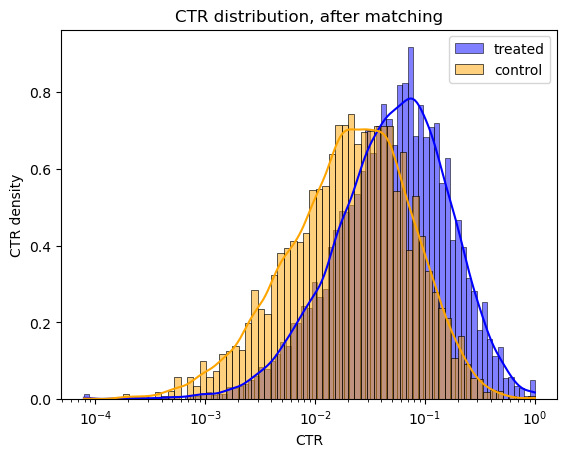

In [24]:
# Remove null values because log_scale is set to true for better visualization
df_treatment = df_matched_treatment.loc[df_matched_treatment["CTR"] != 0] 
df_control = df_matched_control.loc[df_matched_control["CTR"] != 0]

ax = sns.histplot(df_treatment['CTR'], stat='density', kde=True,  color='blue', label='treated', log_scale=True)
ax = sns.histplot(df_control['CTR'], stat='density', kde=True,  color='orange', label='control', log_scale=True)
ax.set(title='CTR distribution, after matching',xlabel='CTR', ylabel='CTR density')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Linear Regression of CTR on ypos')

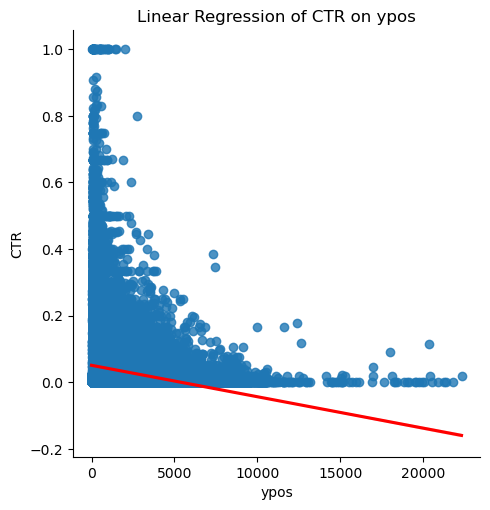

In [25]:
sns.lmplot(x="ypos", y="CTR", data=df_matched, line_kws={'color': 'red'}) #linear regression
ax = plt.gca()
ax.set_title('Linear Regression of CTR on ypos')

In [26]:
print(stats.pearsonr(df_matched['ypos'],df_matched['CTR']))

PearsonRResult(statistic=-0.20652062407096294, pvalue=0.0)


Again, the p-value shows a significant effect of the position on the CTR (< 0.05). This, indeed, confirms that **the higher a link is positioned, the higher its CTR will be.**

Let's push further the analysis by matching only links that have the same article source!

In [27]:
matching = [] # store the matched data points from the control group

for id_row, row in df_links.iterrows():  
    
    # If the row is in the control group 
    if row['is_on_top'] == 0:  
        df_links.loc[id_row, 'matched'] = np.nan  # because we want to match 
                                                  # each treated link with a control one and not the opposite.
    # else if the row is in the treated group   
    else: 
        # for each link in the treated group, loop over its k neighbors
        for neighbor_id in neighbor_ids[id_row, :]:
            
            # check if the neighbor is in the control group and the treated link is not matching with itself
            # and the link source of the treated link is the same as the control link
            if (id_row != neighbor_id) and (df_links.loc[neighbor_id, 'is_on_top'] == 0) and (row['linkSource'] == df_links.loc[neighbor_id, 'linkSource']):
                
                # check if the control link have a match already
                if neighbor_id not in matching:  
                    df_links.loc[id_row, 'matched'] = neighbor_id  # match the treated link to a controlled link
                    matching.append(neighbor_id)  # add the matched id from the control group
                    break

In [28]:
# dataframe containing only matched rows from the treated group
df_treatment_matched = df_links.dropna(subset=['matched']) # because links from the control group have NaN values

# indexes of the matched links from the control group to each of the links in the treated group
matched_control_ids = df_treatment_matched['matched'].astype(int)

# dataframe containing only matched rows from the control group
df_control_matched = df_links.loc[matched_control_ids, :] 

# concatenate the matched treatment and control groups into a single dataframe
df_matched = pd.concat([df_treatment_matched, df_control_matched])

# drop NaN CTR values
df_matched.dropna(subset=['CTR'], inplace=True)

In [29]:
# matched control and treatment
df_matched_treatment = df_matched.loc[df_matched['is_on_top'] == 1] #links positioned at the top
df_matched_control = df_matched.loc[df_matched['is_on_top'] == 0] #links positioned at the bottom

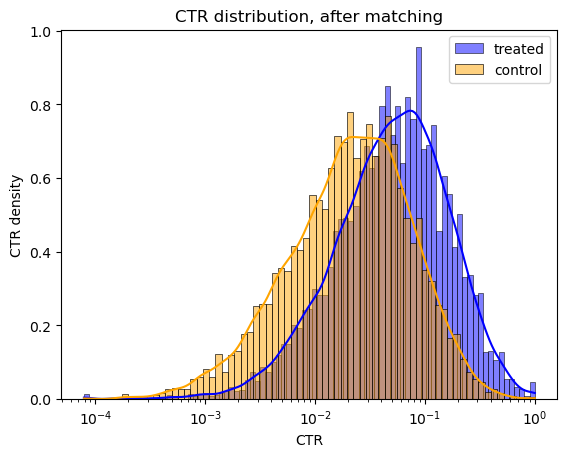

In [30]:
# Remove null values because log_scale is set to true for better visualization
df_treatment = df_matched_treatment.loc[df_matched_treatment['CTR'] != 0] 
df_control = df_matched_control.loc[df_matched_control['CTR'] != 0]

ax = sns.histplot(df_treatment['CTR'], stat='density', kde=True,  color='blue', label='treated', log_scale=True)
ax = sns.histplot(df_control['CTR'], stat='density', kde=True,  color='orange', label='control', log_scale=True)
ax.set(title='CTR distribution, after matching',xlabel='CTR', ylabel='CTR density')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Linear Regression of CTR on ypos')

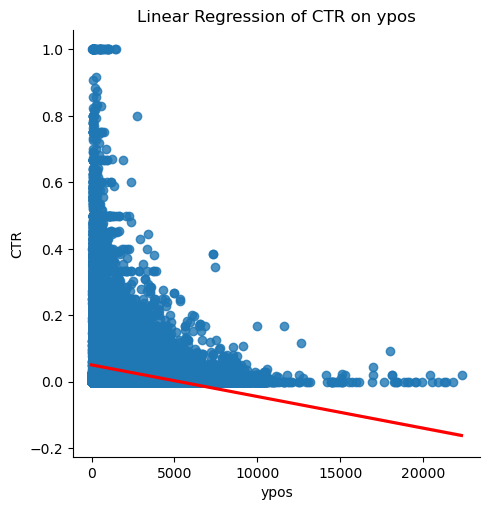

In [31]:
sns.lmplot(x="ypos", y="CTR", data=df_matched, line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title('Linear Regression of CTR on ypos')

In [32]:
print(stats.pearsonr(df_matched['ypos'],df_matched['CTR']))

PearsonRResult(statistic=-0.20642923767247684, pvalue=0.0)


After link matching while sharing the same source article, a negative correlation is found between the CTR and the link position. Again, one can conclude that as the link position increases in the article, its CTR decreases. 